In [1]:
import tensorflow as tf
import os
import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt



In [2]:
tf.keras.utils.image_dataset_from_directory??

In [3]:
data_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

train_data = os.path.join(data_dir,'train')

class_names = ['fake', 'real']

train = tf.keras.utils.image_dataset_from_directory(train_data,class_names=class_names)

Found 100000 files belonging to 2 classes.


In [4]:
valid_data = os.path.join(data_dir,'valid')
test_data = os.path.join(data_dir,'test')

valid = tf.keras.utils.image_dataset_from_directory(valid_data,class_names=class_names)
test = tf.keras.utils.image_dataset_from_directory(test_data,class_names=class_names)

Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [5]:
train = train.map(lambda x,y: (x/255, y))
scaled_iterator = train.as_numpy_iterator()

In [6]:
batch1 = scaled_iterator.next()
batch1[0].max()

1.0

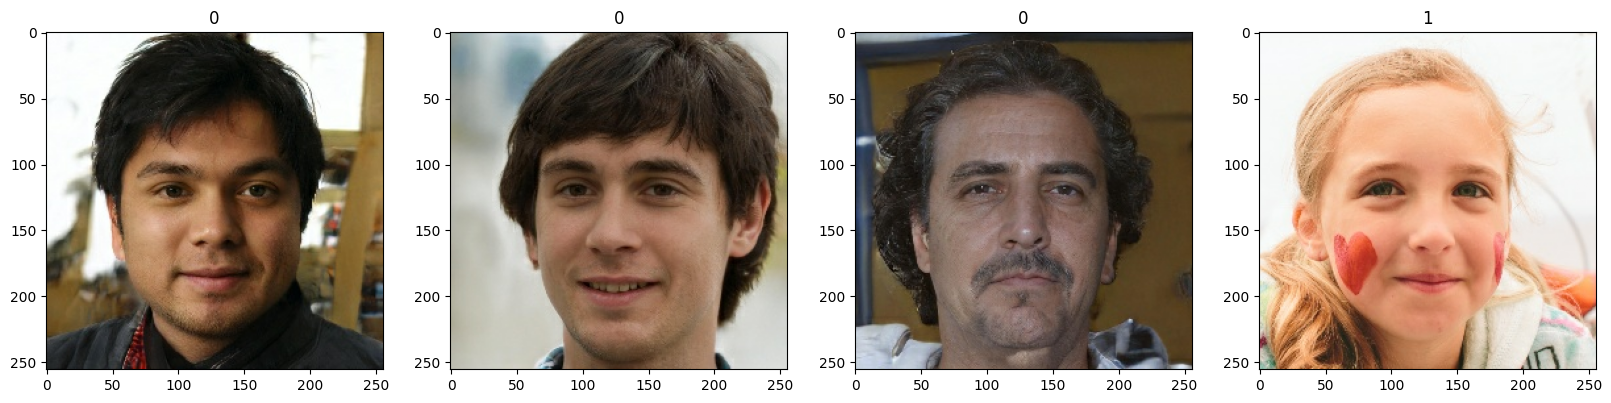

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch1[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch1[1][idx])

In [8]:
valid = valid.map(lambda x,y: (x/255, y))
scaled_iterator = valid.as_numpy_iterator()
batch2 = scaled_iterator.next()
batch2[0].max()

1.0

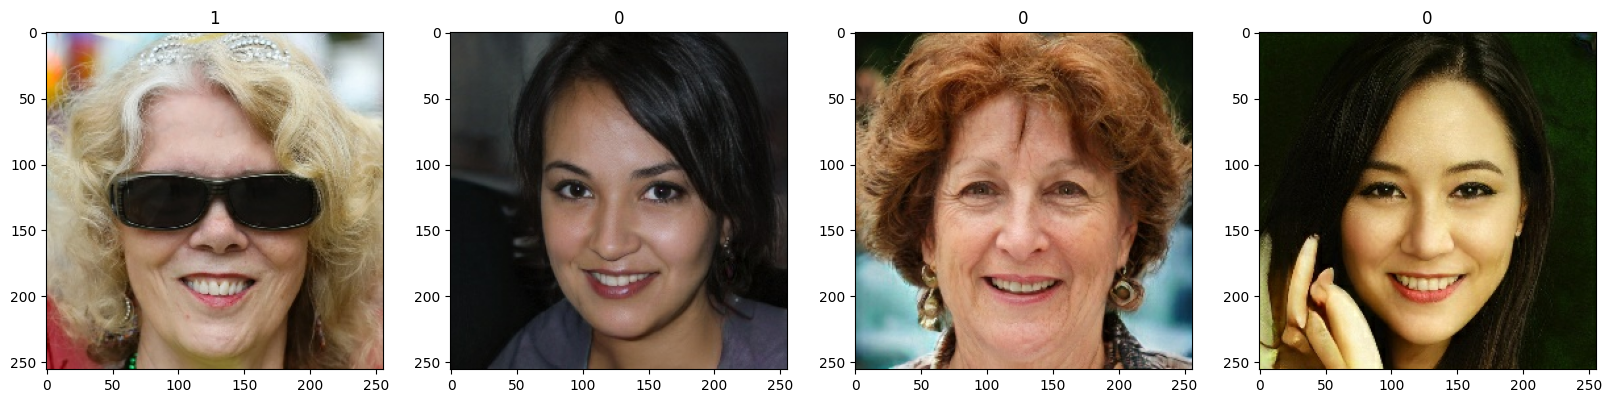

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch2[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch2[1][idx])

Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers, models

In [11]:
model = Sequential()

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [13]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())
# model.add(Dense(512, activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,584,961 (112.86 MB)

 Trainable params: 29,584,961 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )
# checkpoint_filepath = "model_cp.h5"
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoint_filepath = 'model_checkpoints/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.weights.h5'

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',  # Minimize the loss value
    save_best_only=True
)


In [17]:
hist = model.fit(train, epochs=70, validation_data=valid, callbacks=[tensorboard_callback,reduce_lr,checkpoint_cb])

Epoch 1/70


I0000 00:00:1732548733.343872      74 service.cc:145] XLA service 0x7c1b24098860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732548733.343946      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732548733.343951      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732548743.983389      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 225s 68ms/step - accuracy: 0.6020 - loss: 0.8233 - val_accuracy: 0.7993 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 2/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 200s 64ms/step - accuracy: 0.7878 - loss: 0.6138 - val_accuracy: 0.8523 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 3/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 201s 64ms/step - accuracy: 0.8330 - loss: 0.5432 - val_accuracy: 0.8727 - val_loss: 0.4869 - learning_rate: 0.0010
Epoch 4/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 200s 64ms/step - accuracy: 0.8550 - loss: 0.5098 - val_accuracy: 0.8927 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 5/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 199s 64ms/step - accuracy: 0.8694 - loss: 0.4794 - val_accuracy: 0.8981 - val_loss: 0.4211 - learning_rate: 0.0010
Epoch 6/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 200s 64ms/step - accuracy: 0.8804 - loss: 0.4590 - val_accuracy: 0.9091 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch 7/70
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 200s 64ms/step - accuracy: 

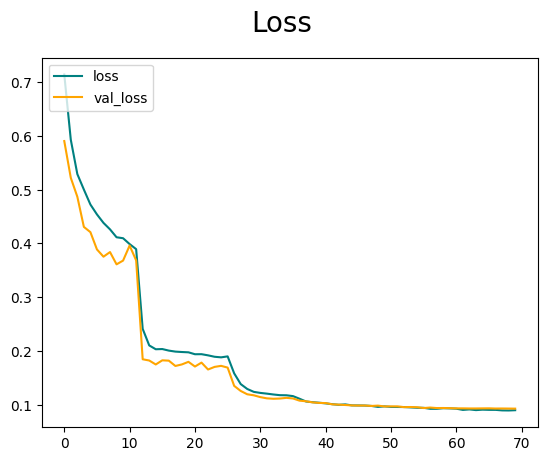

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

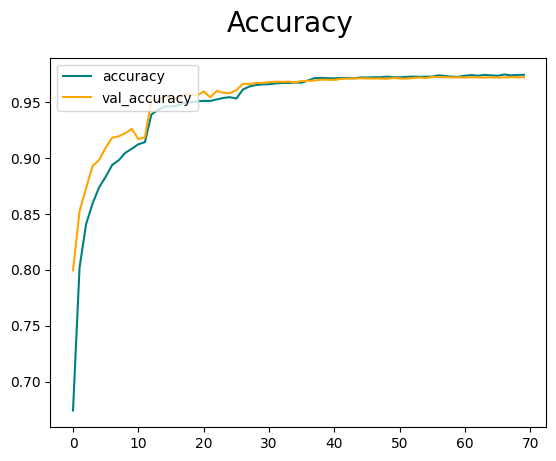

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [21]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

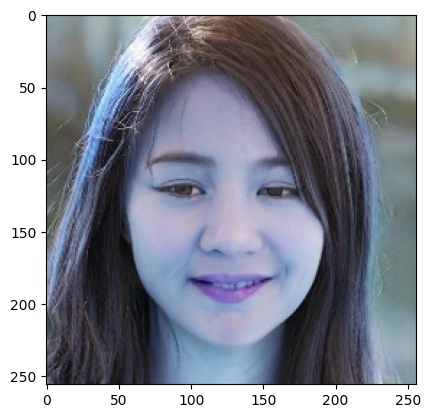

In [22]:
img = cv2.imread('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg')
plt.imshow(img)
plt.show()

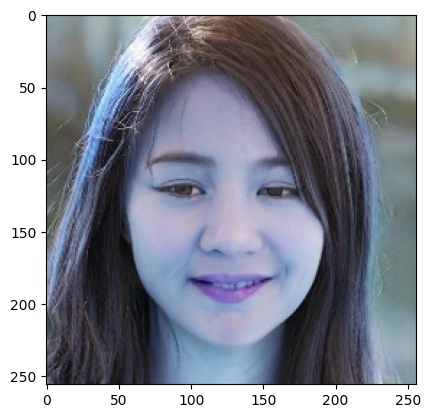

In [23]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [24]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


In [25]:
yhat

array([[0.5078113]], dtype=float32)

In [26]:
if yhat > 0.5: 
    print(f'Predicted class is real')
else:
    print(f'Predicted class is fake')

Predicted class is real


In [27]:
from tensorflow.keras.models import load_model

model.save('FaceClassifier.h5') #faceClassigfication.keras

In [28]:
new_model = load_model('FaceClassifier.h5')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


array([[0.5078113]], dtype=float32)